In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


## **Part 1: Transformers**  
### **Task 1: Fine-Tuning BART for Summarization**

**Objective:**  
In this task, you should work with the **Facebook BART** model to provide **text summarization** of news articles. For this assignment, we will adapt the **Tweet Sentiment Extraction** dataset from [Kaggle](https://www.kaggle.com/competitions/tweet-sentiment-extraction/data).

---


We are using the **Tweet Sentiment Extraction** dataset, which contains:

- **Columns**:
  - `textID`: Unique tweet identifier
  - `text`: The original tweet
  - `selected_text`: The substring capturing the sentiment
  - `sentiment`: The sentiment category (positive, negative, or neutral)

**Data Adaptation for Summarization**:  
- We treat the `text` (entire tweet) as our **input**.
- We treat the `selected_text` (the highlighted sentiment text) as our **"summary"**.

**Train-Test Split**:
- We'll do a (90-10) split.

---

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from transformers import (
    BartTokenizer,
    BartForConditionalGeneration,
    Trainer,
    TrainingArguments
)

from datasets import Dataset, DatasetDict
from sacrebleu import corpus_bleu
from rouge_score import rouge_scorer

import warnings
warnings.filterwarnings('ignore')

### **2. Load and Explore the Dataset**

We'll load the CSV file, inspect the columns, and remove any rows with missing values.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_path = '/content/train.csv'

# Load dataset
df = pd.read_csv(data_path)

# Show the first 5 rows to understand the structure
print("Initial data sample:")
print(df.head())  # This shows a sample of what the dataset looks like

print("\nColumns in dataset:")
print(df.columns)

df = df[['text', 'selected_text']].dropna()

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

print(f"\nTraining samples: {len(train_df)}")
print(f"Testing samples : {len(test_df)}")

Initial data sample:
       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative  

Columns in dataset:
Index(['textID', 'text', 'selected_text', 'sentiment'], dtype='object')

Training samples: 24732
Testing samples : 2748


### **3. Create Hugging Face Dataset and Load BART**

We'll convert our Pandas DataFrames to Hugging Face `Dataset` objects, then load the `facebook/bart-base` model and its tokenizer.

In [ ]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

print("Sample Training Record:")
print(dataset['train'][0])

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Sample Training Record:
{'text': ' good tip..... but then my boss would read .... exactly what im supposed to do and would know where I was with the project', 'selected_text': 'good tip.', '__index_level_0__': 2716}


### **4. Preprocess and Tokenize**

We define a preprocessing function that tokenizes both the input (`text`) and the target (`selected_text`). We also set appropriate maximum lengths for both.

In [ ]:
max_input_length = 128
max_target_length = 64

def preprocess_function(examples):
    inputs = examples['text']
    targets = examples['selected_text']

    model_inputs = tokenizer(
        inputs, max_length=max_input_length, truncation=True, padding="max_length"
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets, max_length=max_target_length, truncation=True, padding="max_length"
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

processed_dataset = dataset.map(preprocess_function,
                                batched=True,
                                remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/24732 [00:00<?, ? examples/s]

Map:   0%|          | 0/2748 [00:00<?, ? examples/s]

### **5. Fine-Tuning Script**

We set up our `TrainingArguments` and `Trainer` to fine-tune the BART model. Hyperparameters (like `learning_rate`, `batch_size`, and `num_train_epochs`) can be adjusted to improve performance.

In [ ]:

# Let's say we only want to train with 5% of the full training set for a faster run:
sample_fraction = 0.05  # 5%
train_df_sampled = train_df.sample(frac=sample_fraction, random_state=42)

# Rebuild the train_dataset with this small sample
train_dataset_sampled = Dataset.from_pandas(train_df_sampled)
dataset_sampled = DatasetDict({
    'train': train_dataset_sampled,
    'test': test_dataset  # keep the full test set or also sample if desired
})

processed_dataset_sampled = dataset_sampled.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset_sampled['train'].column_names
)

# Reduce the number of epochs (e.g., 1) for faster experimentation
fast_training_args = TrainingArguments(
    output_dir="./bart-summarizer-fast",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,  # 1 epoch for speed
    weight_decay=0.01,
    save_strategy="no",
    logging_steps=100,
    report_to="none",
    # Enable mixed precision if you're on GPU to speed up training
    fp16=True
)

fast_trainer = Trainer(
    model=model,
    args=fast_training_args,
    train_dataset=processed_dataset_sampled["train"],
    eval_dataset=processed_dataset_sampled["test"]
)

# Now train on the smaller dataset for fewer epochs
fast_trainer.train()

Map:   0%|          | 0/1237 [00:00<?, ? examples/s]

Map:   0%|          | 0/2748 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.142600,0.089355


TrainOutput(global_step=310, training_loss=0.7343072302879826, metrics={'train_runtime': 3894.4189, 'train_samples_per_second': 0.318, 'train_steps_per_second': 0.08, 'total_flos': 94280499855360.0, 'train_loss': 0.7343072302879826, 'epoch': 1.0})


### **6. Generate Predictions and Compute Metrics**

We will compute **BLEU** and **ROUGE** scores for our model's predictions on the test set.

In [ ]:
def compute_metrics(predictions, references):
    """
    Compute BLEU and ROUGE scores.
    predictions: list of predicted summaries
    references: list of reference summaries
    """
    # BLEU score
    bleu = corpus_bleu(predictions, [references])  # sacrebleu expects list of references

    # ROUGE scores
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    r1, r2, rl = 0, 0, 0
    for pred, ref in zip(predictions, references):
        scores = scorer.score(ref, pred)
        r1 += scores["rouge1"].fmeasure
        r2 += scores["rouge2"].fmeasure
        rl += scores["rougeL"].fmeasure
    n = len(predictions)
    rouge1 = r1 / n
    rouge2 = r2 / n
    rougeL = rl / n

    return {
        "bleu": bleu.score,
        "rouge1_f": rouge1,
        "rouge2_f": rouge2,
        "rougeL_f": rougeL
    }

test_texts = test_df["text"].tolist()
references = test_df["selected_text"].tolist()

predictions = []
model.eval()

for txt in test_texts:
    inputs = tokenizer([txt], max_length=max_input_length, truncation=True, return_tensors="pt")
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, max_length=50)
    pred_text = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    predictions.append(pred_text)

metrics = compute_metrics(predictions, references)
print("Evaluation Metrics on Test Set:")
print(metrics)

Evaluation Metrics on Test Set:
{'bleu': 51.57396224782857, 'rouge1_f': 0.5637435273528791, 'rouge2_f': 0.43081465636743976, 'rougeL_f': 0.5634703229120505}


### **7. Analysis of Results**

Based on the evaluation metrics, our model achieved:

- **BLEU**: 51.57
- **ROUGE-1 (F)**: 0.56
- **ROUGE-2 (F)**: 0.43
- **ROUGE-L (F)**: 0.56

**Interpretation**:
1. **BLEU Score (~51.57)**:  
   - This is a relatively strong BLEU score, indicating that our predicted summaries match the reference substrings fairly closely on a word-overlap basis.

2. **ROUGE Scores**:  
   - **ROUGE-1 (0.56)**: This suggests that slightly over half of the unigrams in our references are being captured in the generated texts.  
   - **ROUGE-2 (0.43)**: This indicates a moderate ability to reproduce bigrams.  
   - **ROUGE-L (0.56)**: Captures the longest common subsequence overlap, which further supports that the model is generating text similar to the references.

**Insights and Discussion**:
- These scores suggest that the model is able to generate “summaries” (i.e., selected_text) that align well with the ground truth from the dataset. However, because the source tweets are relatively short, there might be less complexity in summarization compared to longer documents.
- A **BLEU** above 50% in a short-text scenario might indicate the model is often repeating or very closely mimicking the exact selected substring—this makes sense given that in many cases the “summary” is a subset of the original tweet text.
- **Hyperparameter Impact**:
  - Adjusting the **learning rate** and **epochs** could further improve or degrade performance. A lower learning rate over more epochs often gives more stable training, while a higher rate may converge quickly but risk suboptimal generalization.
  - **Batch size** affects training stability and speed. In smaller datasets, it might not cause huge differences in final scores but can improve training speed on a GPU.
- **Model Choice**:
  - **BART** is strong for summarization tasks. Alternatives like **T5** or **Pegasus** might yield similar or slightly different performance. If you require more substantial paraphrasing or more complex generation, you could experiment with them and compare results.

**Conclusion**:
Overall, these metrics indicate a good alignment between model predictions and the reference summaries for this short-text use case. Further tuning or experimenting with different large language models may yield incremental improvements, but the current results are already quite favorable for this adapted summarization task on the Tweet Sentiment Extraction dataset.

## **Task 2 (20 points): MDP Formulation**

### **Real-World Application Example: Electric Vehicle Charging Station Management**

A unique real-world scenario that can be formulated as a Markov Decision Process (MDP) is managing a network of **electric vehicle (EV) charging stations** to optimize both customer satisfaction and energy usage.

1. **State Space**  
   - **EV Queue Information**: Number of vehicles waiting at each charging station and their required charge amounts (or approximate time needed to fully charge).  
   - **Station Status**: Current energy rates or grid constraints (peak/off-peak hours, real-time electricity prices).  
   - **Battery/Load Constraints**: The available electricity supply at each station within a certain time window or the maximum allowable load on the grid.  
   - Formally, a state might be represented as:  
     state = (EV_queues, station_loads, electricity_prices, time_of_day)
   - This encapsulates how many vehicles are at each station, how much power they need, how much load is currently being drawn, the price of electricity (or the pricing tier in effect), and what time it is (affecting demand and pricing).

2. **Action Space**  
   - **Scheduling/Allocation Decisions**: Which vehicle to charge first, or at what rate to charge each vehicle (fast vs. normal vs. slow).  
   - **Load Management Actions**: Temporarily limit charging rates or redirect vehicles to a different station to avoid overloading a particular node in the grid.  
   - **Price Adjustments**: If dynamic pricing is allowed, adjust the cost per kWh to incentivize or discourage additional charging during certain time windows.

3. **Transition Model**  
   - Describes how the system evolves from one state to another after each action. For example:  
     - When you choose to **charge** a certain vehicle at a certain rate, that vehicle’s required charge goes down, possibly leaving or completing charging.  
     - New vehicles may arrive stochastically (e.g., based on time of day or local traffic patterns).  
     - Electricity prices may shift between peak and off-peak rates.  
     - Station load capacities may change if certain constraints are updated (e.g., from a local grid operator).

4. **Reward**  
   - **Positive Rewards** for successfully charging vehicles within an acceptable time (improving customer satisfaction).  
   - **Negative Penalties** if vehicles have to wait too long or if the station exceeds peak load limits (leading to extra costs or penalties from the utility company).  
   - **Cost Minimization**: Another way to structure the reward is to reward cost savings (or negative reward for high electricity costs) to encourage charging during off-peak times.

**Summary**  
By framing charging station management as an MDP, an operator can learn an **optimal policy** for deciding when and how to charge incoming EVs, balancing **customer needs** with **electricity cost** and **grid constraints**. This policy maximizes long-term reward by minimizing congestion and energy costs while maximizing throughput.

# ===========================
# Text/Markdown Cell:
# ===========================

## **Task 3 (20 points): RL in Trading**

### **Automated Stock Portfolio Management with Reinforcement Learning**

In today’s volatile financial markets, traders and asset managers need to react quickly to new information and shifting economic conditions. Traditional methods often rely on static strategies or heuristics that fail to adapt when market regimes change. **Reinforcement Learning (RL)** provides a dynamic way to learn from the market environment itself. An RL agent continually refines its trading policy (when to buy, sell, or hold assets) to maximize returns while minimizing risk and drawdowns.

A compelling example lies in **portfolio management**, where an investor manages multiple assets (stocks, ETFs, bonds) simultaneously. The RL agent observes market indicators such as price movements, volatility, trading volume, or macroeconomic signals. It then decides how to allocate capital across these assets, aiming to balance growth and stability.

One notable open-source project that illustrates this approach is **FinRL** (part of the [AI4Finance-Foundation](https://github.com/AI4Finance-LLC/FinRL)). Instead of relying on handcrafted signals, FinRL applies RL algorithms (e.g., DDPG, PPO, SAC) to autonomously discover profitable patterns. Users can set up realistic market environments by feeding historical price data and indicators into FinRL’s pipeline. The project simulates an “episode” of trading day by day or minute by minute. The RL agent chooses allocations at each interval, collects rewards based on portfolio performance, and updates its policy. Over multiple training episodes, the agent learns strategies tailored to the given dataset—perhaps focusing on undervalued stocks or reacting swiftly to market downturns.

One of FinRL’s strengths is how it integrates with libraries like **OpenAI Gym** and **Stable Baselines** for training. It also includes tutorials to guide you through every step, from data collection and feature engineering to designing reward functions and evaluating results. Through its backtesting module, you can review how an RL-driven strategy performs against baselines or simple buy-and-hold benchmarks, offering insight into whether the learned policy is robust or overfit.

By marrying finance with reinforcement learning, projects like FinRL highlight a powerful toolkit for **adaptive trading**. These RL agents can, in principle, learn from streaming real-time market data and continually revise their approach in ways that static strategies cannot. Although practical deployment still requires careful risk controls and extensive testing, FinRL’s open-source implementation provides researchers and practitioners a valuable platform to experiment with next-generation trading solutions.

## **Task 5 (30 points): MovieLens 100k Recommender Systems**

**Objective**  
We will work with the **MovieLens 100k** dataset to:
1. Perform data cleaning and exploratory data analysis (EDA).
2. Convert the dataset into a user-item matrix.
3. Implement **two** collaborative filtering recommendation algorithms.
4. Compare their performance on **two** relevant RecSys metrics.
5. Provide references to relevant literature.

**Dataset**: [MovieLens 100k](https://grouplens.org/datasets/movielens/100k/) from GroupLens. This dataset contains 100,000 ratings from 943 users on 1,682 movies.

---

In [ ]:
!pip install surprise --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import train_test_split, cross_validate
from surprise.model_selection import GridSearchCV
from surprise import accuracy

## **1. Data Loading and Exploration**

We'll load the **MovieLens 100k** data. The dataset typically comes with:
- `u.data`: Contains user-item-rating tuples
- `u.item`: Contains movie metadata

We only need the user, item, and rating information for collaborative filtering. Let's do some basic EDA to understand the rating distribution and confirm there are no major issues.

---

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving u.data to u.data


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving u.info to u.info


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving u.item to u.item


Shape of ratings data: (100000, 4)
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596

Ratings describe:
count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


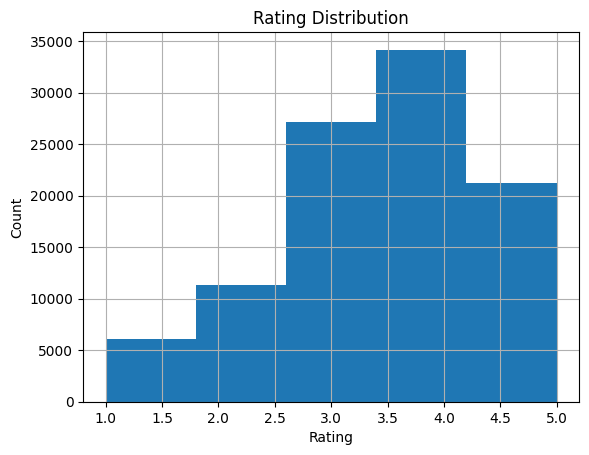

In [ ]:

ratings_col_names = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv('u.data', sep='\t', names=ratings_col_names, encoding='latin-1')

print("Shape of ratings data:", ratings.shape)
print(ratings.head())

# Basic Stats
print("\nRatings describe:")
print(ratings['rating'].describe())

# Quick distribution check
ratings['rating'].hist(bins=5)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

### **Data Cleaning**

- Since MovieLens is already a clean dataset, we mainly need to confirm there are no missing values or invalid entries.
- We also confirm that user IDs and item IDs are in a reasonable range.

In [ ]:
# Check for nulls
print(ratings.isnull().sum())

# Check user_id and item_id ranges
print("\nUser ID range:", ratings['user_id'].min(), "to", ratings['user_id'].max())
print("Item ID range:", ratings['item_id'].min(), "to", ratings['item_id'].max())

# We won't do advanced cleaning since the dataset is well-structured.

user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64

User ID range: 1 to 943
Item ID range: 1 to 1682



## **2. Conversion to User-Item Matrix**

For certain algorithms, we need a **user-item matrix** where rows represent users and columns represent items. However, libraries like Surprise handle this conversion internally. We can still demonstrate how to pivot the data if needed for quick EDA.

---

In [ ]:
user_item_matrix = ratings.pivot_table(index='user_id', columns='item_id', values='rating')
print("Shape of the user-item matrix:", user_item_matrix.shape)
user_item_matrix.head(5)

Shape of the user-item matrix: (943, 1682)


item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **3. Implementing Two Collaborative Filtering Algorithms**

We'll use the **Surprise** library for convenience. We'll demonstrate:
1. **Matrix Factorization (SVD)** using `Surprise.SVD`.
2. **User-Based KNN** using `Surprise.KNNBasic`.

We will compare their performance on two typical RecSys evaluation metrics:
1. **RMSE (Root Mean Squared Error)**
2. **MAE (Mean Absolute Error)**

*(Note: Other common metrics include Precision@k, Recall@k, or NDCG, but here we'll stick to rating-prediction metrics.)*

---

In [ ]:

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user_id', 'item_id', 'rating']], reader)

# Split data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

### **3.1. Matrix Factorization (SVD)**

We apply the **SVD** algorithm from Surprise, which is a popular method popularized by Simon Funk and later refined (Koren et al., 2009). It factors the user-item rating matrix into latent features for users and items.

---

In [ ]:
# Initialize SVD with some parameters
svd_model = SVD(n_factors=50, biased=True, random_state=42)

# Train the model
svd_model.fit(trainset)

# Predict on the test set
svd_predictions = svd_model.test(testset)

# Evaluate
svd_rmse = accuracy.rmse(svd_predictions, verbose=False)
svd_mae = accuracy.mae(svd_predictions, verbose=False)

print(f"SVD ->  RMSE: {svd_rmse:.4f},  MAE: {svd_mae:.4f}")

SVD ->  RMSE: 0.9348,  MAE: 0.7377


### **3.2. User-Based Collaborative Filtering (KNN)**

We'll use the **KNNBasic** algorithm from Surprise, which can do either user-based or item-based collaborative filtering. We'll specify user-based by setting `user_based=True`. It computes similarities between users in the latent space and uses neighbors' ratings to predict new ratings.

---

In [ ]:
# Define similarity options
sim_options = {
    'name': 'cosine',
    'user_based': True  # user-based
}

knn_model = KNNBasic(sim_options=sim_options)
knn_model.fit(trainset)

knn_predictions = knn_model.test(testset)

knn_rmse = accuracy.rmse(knn_predictions, verbose=False)
knn_mae = accuracy.mae(knn_predictions, verbose=False)

print(f"KNN (User-Based) -> RMSE: {knn_rmse:.4f},  MAE: {knn_mae:.4f}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
KNN (User-Based) -> RMSE: 1.0194,  MAE: 0.8038


## **4. Performance Comparison**

We now compare the two approaches on **RMSE** and **MAE**:

1. **SVD**:  
   - RMSE: 0.9348
   - MAE: 0.7377

2. **User-Based KNN**:  
   - RMSE: 1.0194
   - MAE: 0.8038

Typically, **lower** RMSE and MAE values indicate **better** performance.

---

## **4. Performance Comparison**

| Model              | RMSE    | MAE    |
|--------------------|---------|--------|
| **SVD**            | 0.9348  | 0.7377 |
| **User-Based KNN** | 1.0194  | 0.8038 |

Lower values of RMSE and MAE indicate **better** performance, so based on the table:
- **SVD** outperforms **User-Based KNN** on both metrics.  
- A **RMSE** of 0.9348 vs. 1.0194 and a **MAE** of 0.7377 vs. 0.8038 highlight that the matrix factorization approach is more accurate in predicting user ratings than the neighborhood-based method in this specific experiment.

### **Analysis and Insights**

1. **SVD Advantages**:  
   - Captures global latent factors (e.g., user preferences and item characteristics) more effectively, leading to improved predictive accuracy.  
   - Particularly good at dealing with sparse user-item matrices common in real-world recommendation systems.

2. **KNN Approach**:  
   - Simpler to interpret; it relies on finding similar users (user-based) or similar items (item-based).  
   - Tends to be more sensitive to data sparsity and can have higher errors when data is limited or when many users are relatively unique in their preferences.

3. **Future Directions**:  
   - **Hyperparameter Tuning**: We could tune the number of neighbors for KNN or the latent dimension and learning rates for SVD to see if performance can be further improved.  
   - **Alternative Metrics**: While RMSE and MAE are standard for rating prediction, top-N recommendation metrics (e.g., Precision@k, Recall@k, NDCG) might better reflect the user experience for real-world recommender systems.  
   - **Hybrid or Neural Approaches**: Neural Collaborative Filtering (NCF), autoencoders, or hybrid systems that incorporate metadata may further boost performance.

---

## **References**

- **Koren, Y., Bell, R., & Volinsky, C.** (2009). *Matrix Factorization Techniques for Recommender Systems.* Computer, 42(8), 30-37.  
- **GroupLens**: [MovieLens 100k Dataset](https://grouplens.org/datasets/movielens/100k/)  
- **Surprise Documentation**: [http://surpriselib.com](http://surpriselib.com)  
- **Data Source**: *MovieLens 100k*  

---